<center><img src="./images/logo_kbtu.png" width=300 style="display: inline-block;"></center> 

### Week 06. Fully connected neural network from scratch
<br />
<br />
October 12, 2022

In this task, we will implement and train a real neural network with our own hands, “from scratch”!

We'll just have to put some linear classifiers together :)

<center><img src="./images/more_layers.png" width=400></center>

In [1]:
import io
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import scipy.io as scipyio
import urllib.request

from copy import deepcopy

%load_ext autoreload
%autoreload 2

### Loading and “preparing” data

In [3]:
def load_data_mat(path_to_file, max_samples, seed=7):

    with io.open(path_to_file, 'rb+') as tmp_file:
        raw_mat = scipyio.loadmat(tmp_file)
    
    X = raw_mat['X']  # Array of [32, 32, 3, n_samples]
    y = raw_mat['y']  # Array of [n_samples, 1]
    X = np.moveaxis(X, [3], [0])
    y = y.flatten()
    # Fix up class 0 to be 0
    y[y == 10] = 0
    
    np.random.seed(seed)
    samples = np.random.choice(np.arange(X.shape[0]),
                               max_samples,
                               replace=False)
    
    return X[samples].astype(np.float32), y[samples]


In [4]:
%%time
# from http://ufldl.stanford.edu/housenumbers/train_32x32.mat
train_X, train_y = load_data_mat('train_32x32.mat', max_samples=10000)

CPU times: user 1.39 s, sys: 177 ms, total: 1.56 s
Wall time: 1.58 s


In [5]:
%%time
# from http://ufldl.stanford.edu/housenumbers/test_32x32.mat
test_X, test_y = load_data_mat('test_32x32.mat', max_samples=1000)

CPU times: user 553 ms, sys: 49.4 ms, total: 602 ms
Wall time: 601 ms


In [6]:
train_X.shape

(10000, 32, 32, 3)

In [8]:
train_X[0, 5, :, 0]

array([ 64.,  65.,  61.,  55.,  52.,  51.,  52.,  57.,  66.,  81.,  94.,
       107., 117., 122., 127., 127., 125., 124., 124., 121., 116., 109.,
       100.,  92.,  90.,  94., 100., 102., 107., 114., 119., 118.],
      dtype=float32)

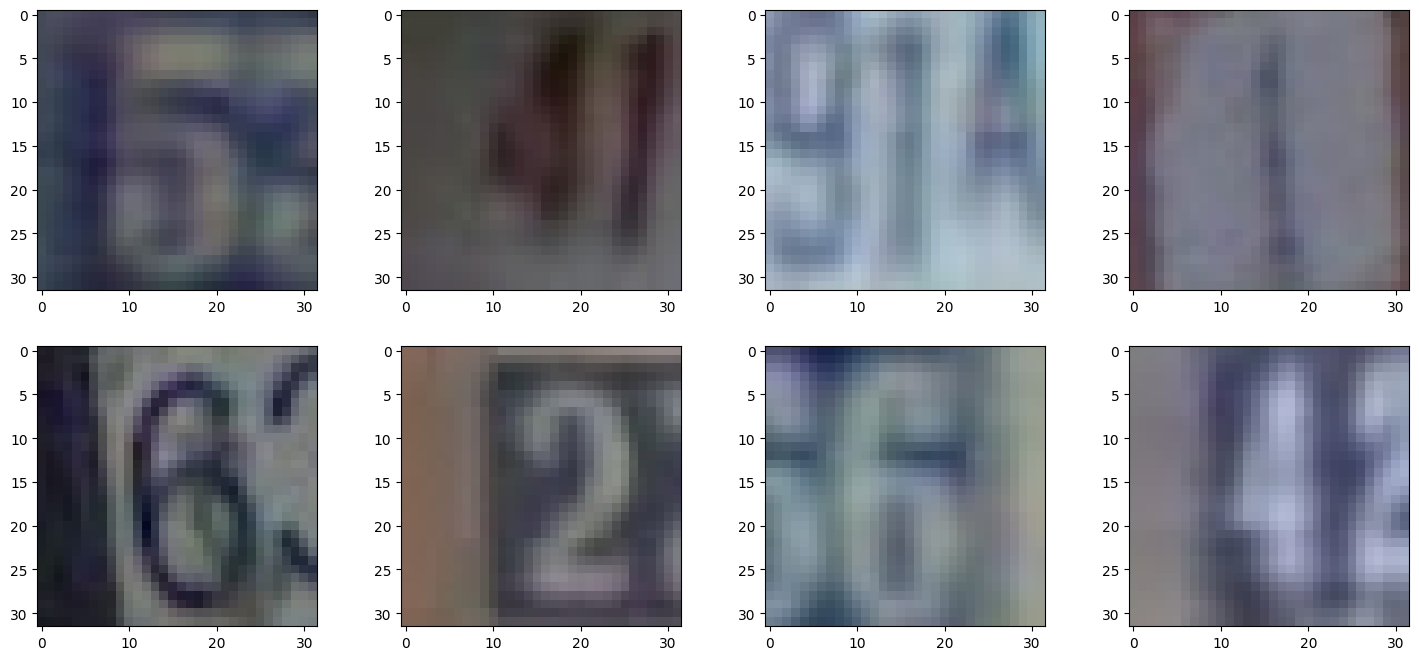

In [7]:
fig, gs = plt.figure(figsize=(18, 8)), matplotlib.gridspec.GridSpec(2, 4)

for i in range(8):
    plot = fig.add_subplot(gs[i])
    plot.imshow(train_X[i].astype(int))

plt.show()

In [9]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float64) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float64) / 255.0
    
    # minus mean for centering
    mean_image = np.mean(train_flat, axis=0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat

def random_split_train_val(X, y, num_val, seed=42):
    np.random.seed(seed)

    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    train_indices = indices[:-num_val]
    train_X = X[train_indices]
    train_y = y[train_indices]

    val_indices = indices[-num_val:]
    val_X = X[val_indices]
    val_y = y[val_indices]

    return train_X, train_y, val_X, val_y


And we also divide the data into training and validation:

In [10]:
train_X, test_X = prepare_for_neural_network(train_X, test_X)

# split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val=1000)

In [11]:
train_X.shape

(9000, 3072)

### We will definitely check ourselves

In general, in this part of the course, we will write many functions that calculate gradients analytically.

All functions in which we will calculate gradients will be written according to the same scheme.
They will receive an input point where you need to calculate **the value and gradient** of the function, and at the output they will produce a tuple of two values 
- the actual value of the function at this point (always one number) and 
- the analytical value of the gradient at the same point (the same dimensions as the input)

```
def f(x):
    r"""
    Computes function and analytic gradient at `x`
    
    Parameters
    ----------
    x : ndarray of float
      Input to the function
    
    returns
    -------
    value : float
      Value of the function
    grad : ndarray of float
      Same shape as `x`
    """
    ...
    
    return value, grad
```

A necessary tool during the implementation of code that calculates gradients is a function to check it. This function calculates the gradient numerically and checks the result against the gradient computed analytically.

For verification, we will use functions that calculate the gradient using the numerical derivative for each coordinate. To calculate the derivative, we use the two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

$$ \frac{f(x+\delta)-f(x-\delta)}{2\delta}$$

In [12]:
def check_gradient(f, x, delta=1e-5, tol=1e-4):
    r"""
    Checks the implementation of analytical gradient by comparing
    it to numerical gradient using two-point formula

    Parameters
    ----------
    f 
      Function that receives `x` and computes value and gradient
    x : ndarray
      Initial point where gradient is checked
    delta : float
      Step to compute numerical gradient
    tol: float 
      Tolerance for comparing numerical and analytical gradient

    Returns
    -------
      Bool indicating whether gradients match or not
    """
    assert isinstance(x, np.ndarray)
    assert x.dtype == np.float64

    fx, analytic_grad = f(x)
    analytic_grad = analytic_grad.copy()

    assert analytic_grad.shape == x.shape

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        analytic_grad_at_ix = analytic_grad[ix]
        numeric_grad_at_ix = 0

        delta_array = np.zeros(x.shape)
        delta_array[ix] = delta
        fx_add_delta, _ = f(x + delta_array)
        fx_sub_delta, _ = f(x - delta_array)

        numeric_grad_at_ix = (fx_add_delta - fx_sub_delta) / (2 * delta)

        if not np.isclose(numeric_grad_at_ix, analytic_grad_at_ix, tol):
            print("Gradients are different at %s. Analytic: %2.5f, Numeric: %2.5f" % (
                  ix, analytic_grad_at_ix, numeric_grad_at_ix))
            return False

        it.iternext()

    print("Gradient check passed!")
    return True


def check_layer_gradient(layer, x, delta=1e-5, tol=1e-4):
    r"""
    Checks gradient correctness for the input and output of a layer

    Parameters
    ----------
    layer 
      Neural network layer, with forward and backward functions
    x
      Starting point for layer input
    delta : float
      Step to compute numerical gradient
    tol : float
      Tolerance for comparing numerical and analytical gradient

    Returns
    -------
      Bool indicating whether gradients match or not
    """
    output = layer.forward(x)
    output_weight = np.random.randn(*output.shape)

    def helper_func(x):
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        grad = layer.backward(d_out)
        return loss, grad

    return check_gradient(helper_func, x, delta, tol)


def check_layer_param_gradient(layer, x,
                               param_name,
                               delta=1e-5, tol=1e-4):
    r"""
    Checks gradient correctness for the parameter of the layer

    Parameters
    ----------
    layer
      Neural network layer, with forward and backward functions
    x
      Starting point for layer input
    param_name
      Name of the parameter
    delta : float
      Step to compute numerical gradient
    tol : float
      Tolerance for comparing numerical and analytical gradient

    Returns
    -------
      Bool indicating whether gradients match or not
    """
    param = layer.params()[param_name]
    initial_w = param.value

    output = layer.forward(x)
    output_weight = np.random.randn(*output.shape)

    def helper_func(w):
        param.value = w
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        layer.backward(d_out)
        grad = param.grad
        return loss, grad

    return check_gradient(helper_func, initial_w, delta, tol)


def check_model_gradient(model, X, y,
                         delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for all model parameters

    Parameters
    ----------
    model
      Neural network model with compute_loss_and_gradients
    X : ndarray
      Batch of input data
    y : ndarray
      Batch of labels
    delta : float 
      Step to compute numerical gradient
    tol : float
      Tolerance for comparing numerical and analytical gradient

    Returns
    -------
      Bool indicating whether gradients match or not
    """
    params = model.params()

    for param_key in params:
        print("Checking gradient for %s" % param_key)
        param = params[param_key]
        initial_w = param.value

        def helper_func(w):
            param.value = w
            loss = model.compute_loss_and_gradients(X, y)
            grad = param.grad
            return loss, grad

        if not check_gradient(helper_func, initial_w, delta, tol):
            return False

    return True


### Now we start with layers

We will implement the layers we need one by one. Each layer must implement:
- forward pass, which generates the output of the layer on the input and remembers the necessary data
- backward pass, which receives the gradient from the output of the layer and calculates the gradient from the input and parameters

Let's start with `ReLU`, which has no parameters.

In [13]:
class ReLULayer:
    def __init__(self):
        self.X = None

    def forward(self, X):
        # TODO: Implement forward pass
        # Hint: you'll need to save some information about X
        # to use it later in the backward pass
        self.X = X
        return np.maximum(X, 0)

    def backward(self, d_out):
        r"""
        Backward pass

        Parameters
        ----------
        d_out : ndarray, shape(batch_size, num_features)
            Gradient of loss function with respect to output

        Returns
        -------
        d_result : ndarray, shape(batch_size, num_features)
            Gradient with respect to input
        """
        # TODO: Implement backward pass
        # Your final implementation shouldn't have any loops
        d_result = d_out * (self.X > 0)
        return d_result

    def params(self):
        # ReLU Doesn't have any parameters
        return {}


In [14]:
# DONE: Implement ReLULayer layer

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


And now let's implement a fully connected layer, which will have two arrays of parameters: W (weights) and B (bias).

All parameters of our layers will use a special `Param` class for parameters, which will store the values of the parameters and the gradients of these parameters, calculated during the back pass.

This will make it possible to accumulate (sum) gradients from different parts of the loss function, for example, from `cross-entropy loss` and `regularization loss`.

In [20]:
class Param:
    r"""
    Trainable parameter of the model
    Captures both parameter value and the gradient
    """

    def __init__(self, value):
        self.value = value
        self.grad = np.zeros_like(self.value)


In [21]:
class FullyConnectedLayer:
    def __init__(self, n_input, n_output):
        self.W = Param(0.001 * np.random.randn(n_input, n_output))
        self.B = Param(0.001 * np.random.randn(1, n_output))
#         self.W = Param(np.random.normal(0, sqrt(2 / n_input), (n_input, n_output)))
#         self.B = Param(np.random.normal(0, sqrt(2 / n_input), n_output))
        self.X = None

    def forward(self, X):
        # TODO: Implement forward pass
        # Your final implementation shouldn't have any loops
        self.X = deepcopy(X)

        return (X @ self.W.value) + self.B.value

    def backward(self, d_out):
        r"""
        Backward pass
        Computes gradient with respect to input and
        accumulates gradients within self.W and self.B

        Parameters
        ----------
        d_out, ndarray of shape(batch_size, n_output)
          Gradient of loss function with respect to output

        Returns
        -------
        d_result : ndarray of shape(batch_size, n_input) 
          Gradient with respect to input
        """
        # TODO: Implement backward pass
        # Compute both gradient with respect to input
        # and gradients with respect to W and B
        # Add gradients of W and B to their `grad` attribute
        d_input = d_out @ self.W.value.T
        self.W.grad += self.X.T @ d_out
        self.B.grad += np.sum(d_out, axis=0)

        return d_input

    def params(self):
        return {'W': self.W, 'B': self.B}


In [22]:
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)

assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


### Helper functions for neural network implementation

In [23]:
def convert_1d_to_2d_array(array):
    r"""Util function to convert array"""
    if(array.ndim == 1):
        return array[np.newaxis, :].copy()
    else:
        return array.copy()

def softmax_with_cross_entropy(predictions, target_index):
    r"""Computes softmax and cross-entropy loss for model predictions,
    including the gradient.

    Parameters
    ----------
    predictions : ndarray, shape(num_classes) or shape(batch_size, num_classes)
        Classifier output.
    target_index : ndarray, shape(1) or shape(batch_size)
        Index(indices) of the true class(es) for given sample(s).

    Returns
    -------
    loss : float
        Computed cross-entropy loss value.
    dpredictions : ndarray
        Array, with the same shape as `predictions`. Gradient of loss value
        with respect to predictions.
    """
    # TODO: implement softmax_with_cross_entropy
    # Your final implementation shouldn't have any loops
    assert isinstance(predictions, np.ndarray)

    is_1D = (predictions.ndim == 1)
    predictions = convert_1d_to_2d_array(predictions)
    batch_size = predictions.shape[0]

    # computational trick for stability
    predictions -= np.max(predictions, axis=1)[:, np.newaxis]
    predictions = np.exp(predictions)

    probs = predictions / np.sum(predictions, axis=1)[:, np.newaxis]

    dprediction = probs.copy()
    dprediction[(np.arange(batch_size), target_index)] -= 1 # Question 3: why we substract 1 here?
    dprediction /= batch_size
    if (is_1D):
        dprediction = np.squeeze(dprediction, axis=0)

    loss_arr = -np.log(probs)
    loss = np.sum(loss_arr[(np.arange(batch_size), target_index)]) / batch_size
    return loss, dprediction
    

def l2_regularization(W, reg_strength):
    r"""Computes L2 regularization loss on weights and its gradient.

    Parameters
    ----------
    W : ndarray, shape(num_features, num_classes)
        Weights.
    reg_strength : float
        Strength of regularization.

    Returns
    -------
    loss : float
        L2 regularization loss.
    gradient : ndarray, shape(num_features, num_classes)
        Gradient of L2 loss value with respect to weights.
    """
    # TODO: implement l2_regularization
    # Your final implementation shouldn't have any loops
    loss = reg_strength * np.sum(np.square(W))
    grad = 2 * reg_strength * W

    return loss, grad


### Create a neural network

Now we will implement the simplest neural network with two fully connected layers and ReLU non-linearity. Implement the `compute_loss_and_gradients` function, it should run a forward and backward pass through both layers to compute the gradients.

Don't forget to implement gradient zeroing at the beginning of the function.

In [24]:
class TwoLayerNet:
    r""" Neural network with two fully connected layers """

    def __init__(self, n_input, n_output, hidden_layer_size, reg):
        r"""
        Initializes the neural network

        Parameters
        ----------
        n_input : int 
          Dimension of the model input
        n_output : int
          Number of classes to predict
        hidden_layer_size : int
          Number of neurons in the hidden layer
        reg : float
          L2 regularization strength
        """
        self.reg = reg
        # TODO Create necessary layers
        self.layers = [
            FullyConnectedLayer(n_input, hidden_layer_size),
            ReLULayer(),
            FullyConnectedLayer(hidden_layer_size, n_output),
        ]

    def compute_loss_and_gradients(self, X, y):
        r"""
        Computes total loss and updates parameter gradients
        on a batch of training examples

        Parameters
        ----------
        X : ndarray of shape(batch_size, input_features)
          Input data
        y : ndarray of shape(batch_size) of int
          Class labels
        """
        # Before running forward and backward pass through the model,
        # clear parameter gradients aggregated from the previous pass
        # TODO Set parameter gradient to zeros
        # Hint: using self.params() might be useful!

        params = self.params()
        for param_name, param in params.items():
            param.grad = np.zeros_like(param.grad)

        # TODO Compute loss and fill param gradients
        # by running forward and backward passes through the model

        last_output = self.layers[0].forward(X)
        for layer in self.layers[1:]:
            last_output = layer.forward(last_output)

        loss, d_loss = softmax_with_cross_entropy(last_output, y)

        d_next = self.layers[-1].backward(d_loss)
        for layer in self.layers[-2::-1]:
            d_next = layer.backward(d_next)

        # After that, implement l2 regularization on all params
        # Hint: self.params() is useful again!
        for param_name, param in params.items():
            reg_val, reg_grad = l2_regularization(param.value, self.reg)
            param.grad += reg_grad
            loss += reg_val
        return loss

    def predict(self, X):
        r"""
        Produces classifier predictions on the set

        Parameters
        ----------
          X : ndarray of shape(test_samples, num_features)

        Returns
        -------
          y_pred : ndarray of shape(test_samples) of int
        """
        # TODO: Implement predict
        # Hint: some of the code of the compute_loss_and_gradients
        # can be reused
        predictions = self.layers[0].forward(X)
        for layer in self.layers[1:]:
            predictions = layer.forward(predictions)

        pred = np.argmax(predictions, axis=1)
        return pred

    def params(self):
        result = {}

        # TODO Implement aggregating all of the params
        counter = 1
        for layer in self.layers:
            new_params = layer.params()
            if new_params:
                result['W_{}'.format(counter)] = new_params['W']
                result['B_{}'.format(counter)] = new_params['B']
                counter += 1
        return result


In [25]:
# TODO: In TwoLayerNet, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=3, reg=0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO: Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_1
Gradient check passed!
Checking gradient for B_1
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Now let's add regularization to the model — it should add to the loss and make its contribution to the gradients.

In [28]:
# TODO: Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=3, reg=1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_1
Gradient check passed!
Checking gradient for B_1
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

We also implement the function of predicting (calculating the value) of the model on new data.

What accuracy value do we expect to see before training starts?

In [29]:
def multiclass_accuracy(prediction, ground_truth):
    r"""
    Computes metrics for multiclass classification

    Parameters
    ----------
    prediction : ndarray of shape(num_samples) of int
      Model predictions
    ground_truth : ndarray of shape(num_samples) of int
      True labels

    Returns
    -------
    accuracy
      Ratio of accurate predictions to total samples
    """
    N = prediction.size
    accuracy = np.sum(prediction == ground_truth) / N
    
    return accuracy

In [30]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.06666666666666667

In [31]:
model_with_reg.predict(train_X[:30])

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5])

# Add code for the training process

If everything is implemented correctly, the value of the error function should decrease with each epoch, albeit slowly. Don't worry about validation accuracy for now.

In [33]:
class Dataset:
    r"""
    Utility class to hold training and validation data
    """

    def __init__(self, train_X, train_y, val_X, val_y):
        self.train_X = train_X
        self.train_y = train_y
        self.val_X = val_X
        self.val_y = val_y


class Trainer:
    r"""
    Trainer of the neural network models
    Perform mini-batch SGD with the specified data, model,
    training parameters and optimization rule
    """

    def __init__(self, model, dataset, optim,
                 num_epochs=20,
                 batch_size=1000,
                 learning_rate=1e-2,
                 learning_rate_decay=1.0):
        r"""
        Initializes the trainer

        Parameters
        ----------
        model
          Neural network model
        dataset : instance of Dataset class
          Data to train on
        optim
          Optimization method
        num_epochs : int
          Number of epochs to train
        batch_size : int
        learning_rate : float
          Initial learning rate
        learning_rate_decay : float
          Ratio for decaying learning rate every epoch
        """
        self.dataset = dataset
        self.model = model
        self.optim = optim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.learning_rate_decay = learning_rate_decay

        self.optimizers = None

    def setup_optimizers(self):
        params = self.model.params()
        self.optimizers = {}
        for param_name, param in params.items():
            self.optimizers[param_name] = deepcopy(self.optim)

    def compute_accuracy(self, X, y):
        """
        Computes accuracy on provided data using mini-batches
        """
        indices = np.arange(X.shape[0])
        sections = np.arange(self.batch_size, X.shape[0], self.batch_size)
        batches_indices = np.array_split(indices, sections)

        pred = np.zeros_like(y)

        for batch_indices in batches_indices:
            batch_X = X[batch_indices]
            pred_batch = self.model.predict(batch_X)
            pred[batch_indices] = pred_batch

        return multiclass_accuracy(pred, y)

    def fit(self):
        r"""
        Trains a model
        """
        if self.optimizers is None:
            self.setup_optimizers()

        num_train = self.dataset.train_X.shape[0]

        loss_history = []
        train_acc_history = []
        val_acc_history = []
        
        for epoch in range(self.num_epochs):
            print('Started epoch {} / {}'.format(epoch, self.num_epochs))
            shuffled_indices = np.arange(num_train)
            np.random.shuffle(shuffled_indices)
            sections = np.arange(self.batch_size, num_train, self.batch_size)
            batches_indices = np.array_split(shuffled_indices, sections)

            batch_losses = []

            for batch_indices in batches_indices:
                # TODO: Generate batches based on batch_indices and
                # use model to generate loss and gradients for all the params

                X_batch = self.dataset.train_X[batch_indices]
                y_batch = self.dataset.train_y[batch_indices]

                loss = self.model.compute_loss_and_gradients(X_batch, y_batch)

                for param_name, param in self.model.params().items():
                    optimizer = self.optimizers[param_name]
                    param.value = optimizer.update(param.value, param.grad, self.learning_rate)

                batch_losses.append(loss)

            if np.not_equal(self.learning_rate_decay, 1.0):
                # TODO: Implement learning rate decay
                self.learning_rate *= self.learning_rate_decay

            ave_loss = np.mean(batch_losses)

            train_accuracy = self.compute_accuracy(self.dataset.train_X,
                                                   self.dataset.train_y)

            val_accuracy = self.compute_accuracy(self.dataset.val_X,
                                                 self.dataset.val_y)

            print("\tLoss: %f, Train accuracy: %f, val accuracy: %f" %
                  (batch_losses[-1], train_accuracy, val_accuracy))

            loss_history.append(ave_loss)
            train_acc_history.append(train_accuracy)
            val_acc_history.append(val_accuracy)

        return loss_history, train_acc_history, val_acc_history


In [34]:
class SGD:
    r"""
    Implements vanilla SGD update
    """
    def update(self, w, d_w, learning_rate):
        r"""
        Performs SGD update

        Parameters
        ----------
        w : ndarray
          Weights
        d_w : ndarray 
          Same shape as w — gradient
        learning_rate : float
          Learning rate

        Returns
        -------
        updated_weights : ndarray, same shape as w
        """
        return w - d_w * learning_rate


class MomentumSGD:
    r"""
    Implements Momentum SGD update
    """
    def __init__(self, momentum=0.9):
        self.momentum = momentum
        self.velocity = 0
    
    def update(self, w, d_w, learning_rate):
        r"""
        Performs Momentum SGD update

        Parameters
        ----------
        w : ndarray
          Weights
        d_w : ndarray, same shape as w
          Gradient
        learning_rate : float
          Learning rate

        Returns
        -------
        updated_weights : ndarray same shape as w
        """
        # TODO Implement momentum update
        # Hint: you'll need to introduce some variables to remember
        # velocity from the previous updates
        self.velocity = self.momentum * self.velocity - learning_rate * d_w
        return w + self.velocity


In [35]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=100, reg=0)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), num_epochs=20, learning_rate=1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Started epoch 0 / 20
	Loss: 2.301431, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 1 / 20
	Loss: 2.300030, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 2 / 20
	Loss: 2.297917, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 3 / 20
	Loss: 2.297525, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 4 / 20
	Loss: 2.296930, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 5 / 20
	Loss: 2.294587, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 6 / 20
	Loss: 2.294079, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 7 / 20
	Loss: 2.293008, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 8 / 20
	Loss: 2.290799, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 9 / 20
	Loss: 2.288763, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 10 / 20
	Loss: 2.289783, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 11 / 20
	Loss: 2.287202, Tra

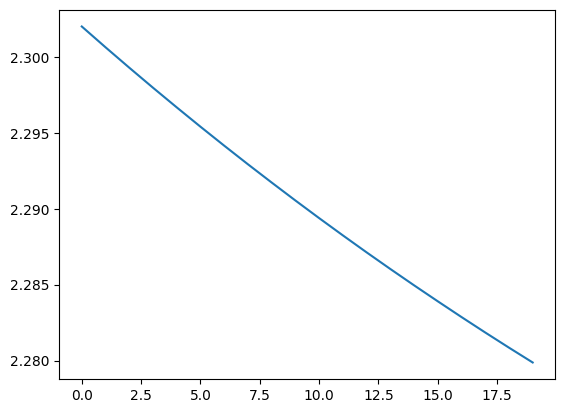

In [36]:
plt.plot(loss_history)

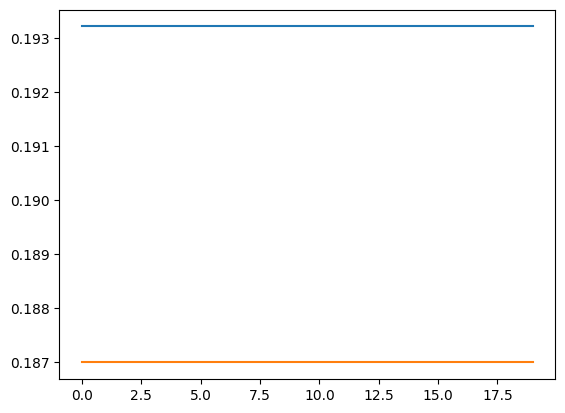

In [37]:
plt.plot(train_history)
plt.plot(val_history)

### Improving the training process

We implement several key optimizations required to train modern neural networks.

### Learning rate decay

One of the necessary optimizations during training of neural networks is the gradual decrease in the learning rate as training progresses.

One of the standard methods is to reduce the learning rate every `N` epochs by a factor `d` (often called decay). The values of `N` and `d`, as always, are hyperparameters and should be chosen based on performance on the validation data.

In our case, `N` will be equal to 1.

In [38]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Started epoch 0 / 20
	Loss: 2.331324, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 1 / 20
	Loss: 2.329128, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 2 / 20
	Loss: 2.326639, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 3 / 20
	Loss: 2.325093, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 4 / 20
	Loss: 2.323911, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 5 / 20
	Loss: 2.321004, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 6 / 20
	Loss: 2.319718, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 7 / 20
	Loss: 2.317450, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 8 / 20
	Loss: 2.315875, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 9 / 20
	Loss: 2.314102, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 10 / 20
	Loss: 2.312829, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 11 / 20
	Loss: 2.312343, Tra

# Momentum Accumulation (Momentum SGD)

Another large class of optimizations is the use of more efficient gradient descent methods. We will implement one of them — momentum accumulation (Momentum SGD).

This method stores the movement speed, uses a gradient to change it at each step, and changes the weights in proportion to the speed value.
(Physical analogy: Instead of velocity, gradients will now specify acceleration, but there will be friction.)

```
velocity = momentum * velocity - learning_rate * gradient
w = w + velocity
```

`momentum` here is the damping factor, which is also a hyperparameter (fortunately, it often has a good default value, a typical range is 0.8-0.99).

Some useful links where the method is analyzed in more detail:
 - http://cs231n.github.io/neural-networks-3/#sgd
 - https://distill.pub/2017/momentum/

In [39]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Started epoch 0 / 20
	Loss: 2.333105, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 1 / 20
	Loss: 2.332949, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 2 / 20
	Loss: 2.332745, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 3 / 20
	Loss: 2.332411, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 4 / 20
	Loss: 2.332212, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 5 / 20
	Loss: 2.331847, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 6 / 20
	Loss: 2.331797, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 7 / 20
	Loss: 2.331383, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 8 / 20
	Loss: 2.331188, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 9 / 20
	Loss: 2.330853, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 10 / 20
	Loss: 2.330923, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 11 / 20
	Loss: 2.330297, Tra

### Well, let's train the network already!

### Final test — overfit on a small dataset

A good way to check if everything is implemented correctly is to overtrain the network on a small data set.
Our model has enough power to fit the small dataset perfectly, so we expect it to quickly get to `100%` accuracy on the training set.

If this does not happen, then somewhere a mistake has been made!

In [40]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Started epoch 0 / 150
	Loss: 2.333335, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 1 / 150
	Loss: 2.306636, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 2 / 150
	Loss: 2.339108, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 3 / 150
	Loss: 2.317838, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 4 / 150
	Loss: 2.322047, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 5 / 150
	Loss: 2.311037, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 6 / 150
	Loss: 2.269924, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 7 / 150
	Loss: 2.192765, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 8 / 150
	Loss: 2.153469, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 9 / 150
	Loss: 2.304834, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 10 / 150
	Loss: 2.416119, Train accuracy: 0.333333, val accuracy: 0.200000
Started epoch 11 / 150
	Loss: 2

	Loss: 1.259115, Train accuracy: 0.866667, val accuracy: 0.200000
Started epoch 93 / 150
	Loss: 1.393360, Train accuracy: 0.933333, val accuracy: 0.200000
Started epoch 94 / 150
	Loss: 1.091427, Train accuracy: 0.866667, val accuracy: 0.200000
Started epoch 95 / 150
	Loss: 1.200655, Train accuracy: 0.866667, val accuracy: 0.200000
Started epoch 96 / 150
	Loss: 1.171851, Train accuracy: 0.933333, val accuracy: 0.200000
Started epoch 97 / 150
	Loss: 1.352329, Train accuracy: 1.000000, val accuracy: 0.200000
Started epoch 98 / 150
	Loss: 1.401205, Train accuracy: 1.000000, val accuracy: 0.200000
Started epoch 99 / 150
	Loss: 1.189069, Train accuracy: 0.933333, val accuracy: 0.200000
Started epoch 100 / 150
	Loss: 1.373643, Train accuracy: 1.000000, val accuracy: 0.200000
Started epoch 101 / 150
	Loss: 1.274510, Train accuracy: 0.933333, val accuracy: 0.200000
Started epoch 102 / 150
	Loss: 1.259370, Train accuracy: 0.933333, val accuracy: 0.200000
Started epoch 103 / 150
	Loss: 1.399423, 

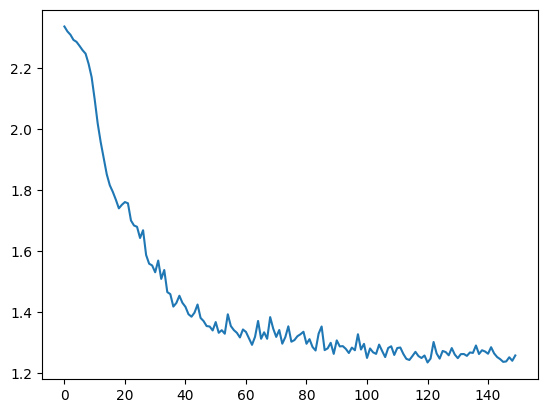

In [41]:
plt.plot(loss_history)

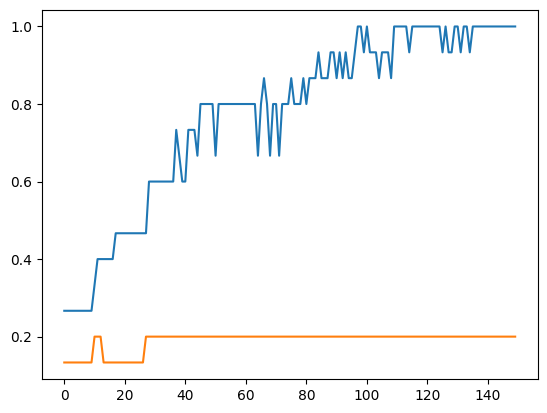

In [42]:
plt.plot(train_history)
plt.plot(val_history)

Let us now find the hyperparameters for which this process converges faster.

If everything is implemented correctly, then there are parameters under which the process converges in **20** epochs or even faster.

In [43]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=200, reg = 0.01)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# DONE: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(momentum=0.9), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Started epoch 0 / 20
	Loss: 2.310512, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 1 / 20
	Loss: 2.321461, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 2 / 20
	Loss: 2.206058, Train accuracy: 0.266667, val accuracy: 0.133333
Started epoch 3 / 20
	Loss: 1.887250, Train accuracy: 0.333333, val accuracy: 0.133333
Started epoch 4 / 20
	Loss: 1.448251, Train accuracy: 0.400000, val accuracy: 0.133333
Started epoch 5 / 20
	Loss: 1.357786, Train accuracy: 0.466667, val accuracy: 0.133333
Started epoch 6 / 20
	Loss: 1.972695, Train accuracy: 0.533333, val accuracy: 0.133333
Started epoch 7 / 20
	Loss: 2.842089, Train accuracy: 0.533333, val accuracy: 0.133333
Started epoch 8 / 20
	Loss: 2.347797, Train accuracy: 0.600000, val accuracy: 0.133333
Started epoch 9 / 20
	Loss: 0.710325, Train accuracy: 0.666667, val accuracy: 0.133333
Started epoch 10 / 20
	Loss: 1.939152, Train accuracy: 0.866667, val accuracy: 0.133333
Started epoch 11 / 20
	Loss: 2.333379, Tra

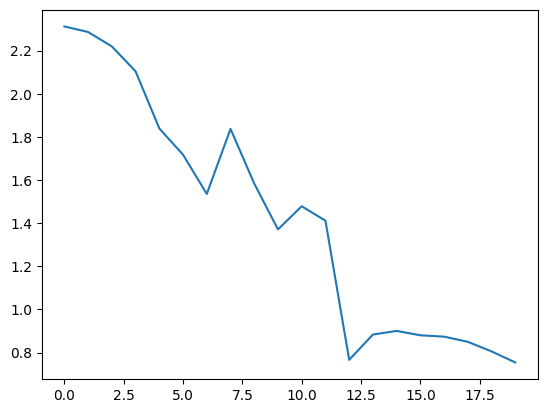

In [44]:
plt.plot(loss_history)

# So, the main event!

Train the best neural network =) You can add and change parameters, change the number of neurons in the layers of the network, and experiment as you like.

You can achieve better than **60%** accuracy on the validation set.

In [45]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-2
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 200
num_epochs = 100
batch_size = 1000

params_list = [
    {'learning_rate': 1e-4, 'reg_strength': 1e-3, 'learning_rate_decay': 0.999},
    {'learning_rate': 1e-4, 'reg_strength': 1e-1, 'learning_rate_decay': 0.999},
    {'learning_rate': 1e-2, 'reg_strength': 1e-3, 'learning_rate_decay': 0.999},
    {'learning_rate': 1e-4, 'reg_strength': 1e-3, 'learning_rate_decay': 0},
    {'learning_rate': 1e-3, 'reg_strength': 1e-2, 'learning_rate_decay': 0.999},
    {'learning_rate': 1e-1, 'reg_strength': 1e-2, 'learning_rate_decay': 0.9},
]

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
dataset = Dataset(train_X, train_y, val_X, val_y)
best_classifier_history = None
best_params = None
best_trainer = None

for param in params_list:
    print('\nStarted learning with new params\n')
    current_lr = param['learning_rate']
    current_reg_str = param['reg_strength']
    current_lr_decay = param['learning_rate_decay']

    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = current_reg_str)
    trainer = Trainer(model, dataset, MomentumSGD(momentum=0.9), learning_rate=current_lr, num_epochs=num_epochs,
                    batch_size=batch_size, learning_rate_decay=current_lr_decay)

    loss_history, train_history, val_history = trainer.fit()
    
    if best_val_accuracy is None:
        best_val_accuracy = max(val_history)
        best_classifier = model
        best_classifier_history = (loss_history, train_history, val_history)
        best_params = param
        best_trainer = trainer
        print('\nFirst best_val_accuracy: {}'.format(best_val_accuracy))
        print('Params init {}'.format(param))
        
    else:
        if max(val_history) > best_val_accuracy:
            best_val_accuracy = max(val_history)
            best_classifier = model
            best_classifier_history = (loss_history, train_history, val_history)
            best_params = param
            best_trainer = trainer
            print('\nNew best_val_accuracy: {}'.format(best_val_accuracy))
            print('New params: {}'.format(param))

print('\nContinue training best model with params: {}\n'.format(best_params))
loss_history, train_history, val_history = best_trainer.fit()

best_classifier_history[0].extend(loss_history)
best_classifier_history[1].extend(train_history)
best_classifier_history[2].extend(val_history)

best_val_accuracy = max(best_classifier_history[2])

print('\nbest validation accuracy achieved: %f' % best_val_accuracy)


Started learning with new params

Started epoch 0 / 100
	Loss: 2.303178, Train accuracy: 0.071222, val accuracy: 0.061000
Started epoch 1 / 100
	Loss: 2.303082, Train accuracy: 0.148111, val accuracy: 0.137000
Started epoch 2 / 100
	Loss: 2.302912, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 3 / 100
	Loss: 2.302788, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 4 / 100
	Loss: 2.302751, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 5 / 100
	Loss: 2.302560, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 6 / 100
	Loss: 2.302479, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 7 / 100
	Loss: 2.302349, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 8 / 100
	Loss: 2.302133, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 9 / 100
	Loss: 2.301866, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 10 / 100
	Loss: 2.301743, Train accuracy: 0.193222, val accuracy: 0.187

	Loss: 2.294467, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 93 / 100
	Loss: 2.292566, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 94 / 100
	Loss: 2.292376, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 95 / 100
	Loss: 2.292340, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 96 / 100
	Loss: 2.291054, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 97 / 100
	Loss: 2.291983, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 98 / 100
	Loss: 2.292183, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 99 / 100
	Loss: 2.291369, Train accuracy: 0.193222, val accuracy: 0.187000

First best_val_accuracy: 0.187
Params init {'learning_rate': 0.0001, 'reg_strength': 0.001, 'learning_rate_decay': 0.999}

Started learning with new params

Started epoch 0 / 100
	Loss: 2.364624, Train accuracy: 0.077889, val accuracy: 0.067000
Started epoch 1 / 100
	Loss: 2.364340, Train accuracy: 0.079000, 

	Loss: 2.340737, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 84 / 100
	Loss: 2.339815, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 85 / 100
	Loss: 2.339615, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 86 / 100
	Loss: 2.340670, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 87 / 100
	Loss: 2.339736, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 88 / 100
	Loss: 2.338293, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 89 / 100
	Loss: 2.341037, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 90 / 100
	Loss: 2.338167, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 91 / 100
	Loss: 2.337430, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 92 / 100
	Loss: 2.338255, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 93 / 100
	Loss: 2.337387, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 94 / 100
	Loss: 2.337421, Trai

	Loss: 1.931288, Train accuracy: 0.325000, val accuracy: 0.316000
Started epoch 76 / 100
	Loss: 1.968130, Train accuracy: 0.334778, val accuracy: 0.325000
Started epoch 77 / 100
	Loss: 1.950957, Train accuracy: 0.342111, val accuracy: 0.331000
Started epoch 78 / 100
	Loss: 1.910077, Train accuracy: 0.351778, val accuracy: 0.333000
Started epoch 79 / 100
	Loss: 1.879755, Train accuracy: 0.357667, val accuracy: 0.340000
Started epoch 80 / 100
	Loss: 1.913367, Train accuracy: 0.364222, val accuracy: 0.348000
Started epoch 81 / 100
	Loss: 1.852923, Train accuracy: 0.373000, val accuracy: 0.354000
Started epoch 82 / 100
	Loss: 1.857874, Train accuracy: 0.378889, val accuracy: 0.352000
Started epoch 83 / 100
	Loss: 1.846007, Train accuracy: 0.385333, val accuracy: 0.358000
Started epoch 84 / 100
	Loss: 1.817984, Train accuracy: 0.392444, val accuracy: 0.367000
Started epoch 85 / 100
	Loss: 1.827099, Train accuracy: 0.397222, val accuracy: 0.371000
Started epoch 86 / 100
	Loss: 1.751169, Trai

	Loss: 2.303029, Train accuracy: 0.065778, val accuracy: 0.069000
Started epoch 67 / 100
	Loss: 2.303060, Train accuracy: 0.065778, val accuracy: 0.069000
Started epoch 68 / 100
	Loss: 2.303068, Train accuracy: 0.065778, val accuracy: 0.069000
Started epoch 69 / 100
	Loss: 2.303034, Train accuracy: 0.065778, val accuracy: 0.069000
Started epoch 70 / 100
	Loss: 2.303052, Train accuracy: 0.065778, val accuracy: 0.069000
Started epoch 71 / 100
	Loss: 2.303052, Train accuracy: 0.065778, val accuracy: 0.069000
Started epoch 72 / 100
	Loss: 2.303071, Train accuracy: 0.065778, val accuracy: 0.069000
Started epoch 73 / 100
	Loss: 2.303088, Train accuracy: 0.065778, val accuracy: 0.069000
Started epoch 74 / 100
	Loss: 2.303082, Train accuracy: 0.065778, val accuracy: 0.069000
Started epoch 75 / 100
	Loss: 2.303046, Train accuracy: 0.065778, val accuracy: 0.069000
Started epoch 76 / 100
	Loss: 2.303033, Train accuracy: 0.065778, val accuracy: 0.069000
Started epoch 77 / 100
	Loss: 2.303089, Trai

	Loss: 2.263221, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 59 / 100
	Loss: 2.273093, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 60 / 100
	Loss: 2.268845, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 61 / 100
	Loss: 2.259619, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 62 / 100
	Loss: 2.268136, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 63 / 100
	Loss: 2.258989, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 64 / 100
	Loss: 2.259260, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 65 / 100
	Loss: 2.261345, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 66 / 100
	Loss: 2.266522, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 67 / 100
	Loss: 2.258712, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 68 / 100
	Loss: 2.253473, Train accuracy: 0.193222, val accuracy: 0.187000
Started epoch 69 / 100
	Loss: 2.265102, Trai

	Loss: 2.101981, Train accuracy: 0.277444, val accuracy: 0.280000
Started epoch 51 / 100
	Loss: 2.071604, Train accuracy: 0.277778, val accuracy: 0.280000
Started epoch 52 / 100
	Loss: 2.086779, Train accuracy: 0.278000, val accuracy: 0.280000
Started epoch 53 / 100
	Loss: 2.062907, Train accuracy: 0.278000, val accuracy: 0.280000
Started epoch 54 / 100
	Loss: 2.062486, Train accuracy: 0.278111, val accuracy: 0.280000
Started epoch 55 / 100
	Loss: 2.068579, Train accuracy: 0.278111, val accuracy: 0.280000
Started epoch 56 / 100
	Loss: 2.094242, Train accuracy: 0.278111, val accuracy: 0.280000
Started epoch 57 / 100
	Loss: 2.078573, Train accuracy: 0.278111, val accuracy: 0.280000
Started epoch 58 / 100
	Loss: 2.066686, Train accuracy: 0.278111, val accuracy: 0.280000
Started epoch 59 / 100
	Loss: 2.070902, Train accuracy: 0.278111, val accuracy: 0.280000
Started epoch 60 / 100
	Loss: 2.080698, Train accuracy: 0.278222, val accuracy: 0.280000
Started epoch 61 / 100
	Loss: 2.064219, Trai

	Loss: 1.354635, Train accuracy: 0.599333, val accuracy: 0.573000
Started epoch 42 / 100
	Loss: 1.296215, Train accuracy: 0.603667, val accuracy: 0.578000
Started epoch 43 / 100
	Loss: 1.350339, Train accuracy: 0.603556, val accuracy: 0.580000
Started epoch 44 / 100
	Loss: 1.334363, Train accuracy: 0.606778, val accuracy: 0.578000
Started epoch 45 / 100
	Loss: 1.327531, Train accuracy: 0.610111, val accuracy: 0.583000
Started epoch 46 / 100
	Loss: 1.348225, Train accuracy: 0.612000, val accuracy: 0.577000
Started epoch 47 / 100
	Loss: 1.380578, Train accuracy: 0.613778, val accuracy: 0.584000
Started epoch 48 / 100
	Loss: 1.335708, Train accuracy: 0.613889, val accuracy: 0.588000
Started epoch 49 / 100
	Loss: 1.290370, Train accuracy: 0.616333, val accuracy: 0.584000
Started epoch 50 / 100
	Loss: 1.254657, Train accuracy: 0.620000, val accuracy: 0.586000
Started epoch 51 / 100
	Loss: 1.306494, Train accuracy: 0.621667, val accuracy: 0.587000
Started epoch 52 / 100
	Loss: 1.312499, Trai

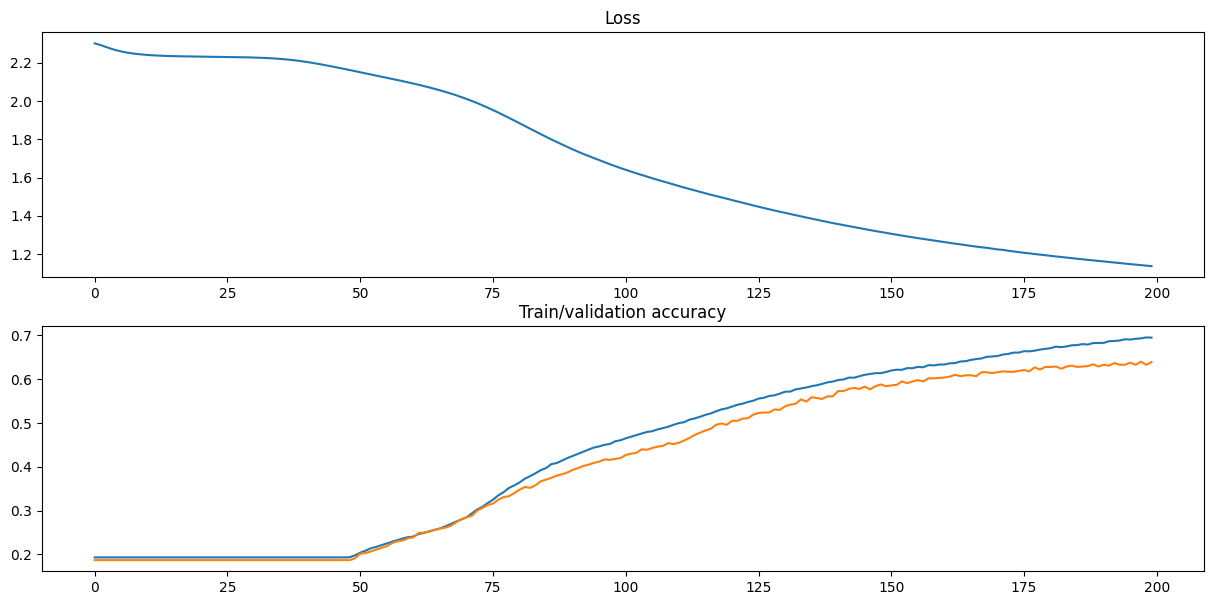

In [46]:
# Continue training best model with params: {'learning_rate': 0.01, 'reg_strength': 0.001, 'learning_rate_decay': 0.999}
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(best_classifier_history[0])
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(best_classifier_history[1])
plt.plot(best_classifier_history[2])

# As usual, let's see how our best model performs on test data

In [47]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.605000
